In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
activation functions and their derivatives
"""

def relu_k(x, k):
    return np.maximum(x**k, 0)

def d_relu_k(x, k):
    return k * x**(k-1) * (x > 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def sin(x, k=None):
    return np.sin(x)

def cos(x, k=None):
    return np.cos(x)

def d_cos(x, k=None):
    return -np.sin(x)

In [3]:
"""
analytic solution: Equation (4)-(5) on page 3

u = <x, x'> / ||x|| ||x'||

k(u) = u k_0(u) + k_1(u)

k_0 = 1/pi (pi - arccos(u))
k_1 = 1/pi (u (pi - arccos(u)) + sqrt(1 - u^2))

assuming x == x'
"""

def kappa(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return u * k_0 + k_1

def analytic_kernel_entry_2d(x, y, num_samples=None, w1=None, w2=None, k=None,activation=None): # x, y vector
    # 'None' params are for fuction call convenience
    # don't need norm_prod because x y are both unit vector, norm=1
    norm_prod = np.linalg.norm(x) * np.linalg.norm(y)
    # for 1d input on line, it's just x * y
    inner_prod = x.dot(y)
    # for numeircal stability: if not -1 < u < 1, arccos(u) is undefined
    if (inner_prod > 1.0):
        inner_prod = 1.0
    if (inner_prod < -1.0):
        inner_prod = -1.0
    u = inner_prod
    
    return kappa(u)

In [4]:
def numerical_kernel_entry(x, y, num_samples, w1, w2, k=1, activation='relu_k'):
    """
    https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf
    equation (3) on page 3 and section 3.3 on page 7 
    
    x, y are vectors
    activation = ['relu_k', 'sin', 'cos']
    d_activation is the derivative of activation function
    
    k=1 means regular relu
    
    K(x, x') = <x, x'> E[sig'(<w, x>)sig'(<w, x'>)] + E[sig(<w, x>)sig(<w, x'>)]
    E {w ~ N(0, 1)}
    """
    
    # w1: (num_samples, 2) x: (2,)
    # get dot products
    w1x = w1.dot(x) # (num_samples,)
    w1y = w1.dot(y) # (num_samples,)
    w2x = w2.dot(x)
    w2y = w2.dot(y)
    
    if activation == 'relu_k':
        activation_func = relu_k
        d_activation = d_relu_k
    elif activation == 'sin':
        activation_func = sin
        d_activation = cos
    elif activation == 'cos':
        activation_func = cos
        d_activation = d_cos        
    
    sigma_w1x = np.asarray(activation_func(w1x, k)) # (num_samples,)
    sigma_w1y = np.asarray(activation_func(w1y, k)) # (num_samples,)
    sigma_w2x = np.asarray(d_activation(w2x, k))
    sigma_w2y = np.asarray(d_activation(w2y, k))  

    # dot product does the summation in a vectorized way
    expection_1 = sigma_w1x.dot(sigma_w1y) / num_samples
    expection_2 = sigma_w2x.dot(sigma_w2y) / num_samples
    
    return 2 * (x.dot(y)) * expection_2 + 2 * expection_1

In [5]:
# execute
def calc_NTK_2d(kernel_entry_func, k=1, activation='relu_k'):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # initialize kernel and sample weights
    kernel = np.zeros((num_inputs, num_inputs))
    num_samples = 1000
    w1, w2 = np.random.normal(0.0, 1.0, size=[2, num_samples, 2])
    
    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = kernel_entry_func(x[:, i], x[:, j], num_samples, w1, w2, k, activation)
    
    # sort eigenvalues in descending order
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    plt.loglog(sorted_eigenvalues[:-1])
    return eigenvalues

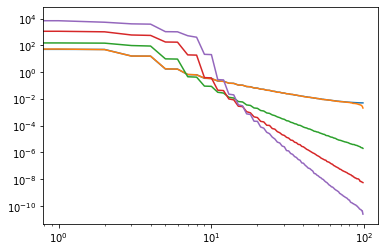

In [6]:
kernel_analytic = calc_NTK_2d(analytic_kernel_entry_2d)
kernel_numerical_k1 = calc_NTK_2d(numerical_kernel_entry, k=1)
kernel_numerical_k2 = calc_NTK_2d(numerical_kernel_entry, k=2)
kernel_numerical_k3 = calc_NTK_2d(numerical_kernel_entry, k=3)
kernel_numerical_k4 = calc_NTK_2d(numerical_kernel_entry, k=4)

In [7]:
"""numerical error"""
# return kernel in calc_NTK_2d instead then run following
# np.max((kernel_numerical_k1 - kernel_analytic), axis=1)

'numerical error'

In [8]:
def calc_NTK_2d_trig(kernel_entry_func, k=1, activation='sin'):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # initialize kernel and sample weights
    kernel = np.zeros((num_inputs, num_inputs))
    num_samples = 1000
    w1, w2 = np.random.normal(0.0, 1.0, size=[2, num_samples, 2])

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = kernel_entry_func(x[:, i], x[:, j], num_samples, w1, w2, k, activation)
    
    # sort eigenvalues in descending order
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    # y log scale keep x , instead of log-log
    plt.yscale('log')
    plt.plot(sorted_eigenvalues)
    return eigenvalues

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


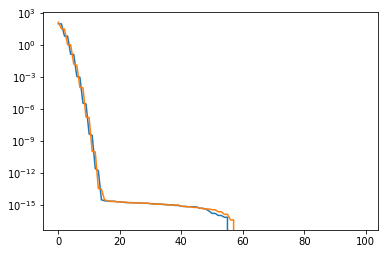

In [9]:
kernel_sin = calc_NTK_2d_trig(numerical_kernel_entry, activation='sin')
kernel_cos = calc_NTK_2d_trig(numerical_kernel_entry, activation='cos')

In [10]:
# calculate Laplace Kernel

def laplace_kernel_entry(x, y, sigma):
    """
    x are y in R^2
    """
    return np.exp(-np.linalg.norm(x - y) / sigma)

In [11]:
# execute
def calc_laplace_2d(sigma):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # init kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = laplace_kernel_entry(x[:, i], x[:, j], sigma)
    
    # sort eigenvalues in descending order
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    # plt.plot(sorted_eigenvalues)
    plt.loglog(sorted_eigenvalues[:-1])

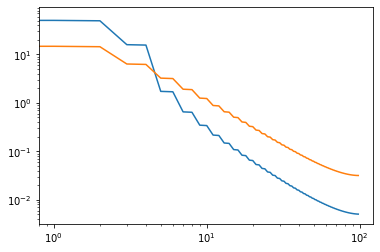

In [12]:
calc_NTK_2d(analytic_kernel_entry_2d)
calc_laplace_2d(sigma=1.0)
# calc_laplace_2d(sigma=1.5)
# calc_laplace_2d(sigma=2.0)